In [303]:
import json

import agama
import h5py
import halo_analysis as halo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore
from scipy.interpolate import PchipInterpolator, interp1d


In [304]:
sim = "m12i"

data_dir = "/Users/z5114326/Documents/GitHub/gc_statistics/data/"
data_file = data_dir + "m12i_time_dep.json"

sim_dir = "/Users/z5114326/Documents/simulations/"
pot_dir = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/potentials/"
potential_snaps = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/external/potentials.json"

fire_dir = sim_dir + sim + "/" + sim + "_res7100/"

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

pub_data = sim_dir + "snapshot_times_public.txt"

# 1. set units (in Msun, Kpc, km/s)
agama.setUnits(mass=1, length=1, velocity=1)

with open(data_file, "r") as file:
    data_dict = json.load(file)

with open(potential_snaps) as json_file:
    pot_data = json.load(json_file)

snap_time_pub = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
snap_time_pub.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

res_df = snap_time_pub[snap_time_pub["index"].isin(pot_data[sim])].reset_index(drop=True)

In [389]:
it = 0

it_min = 0
it_max = 100

######################
data_dict = {}

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)
    src_dat = proc_data[it_id]["source"]
    ana_mask = np.array(src_dat["analyse_flag"]) == 1
    acc_mask = np.array(src_dat["accretion_flag"]) == 1

    surviving_gc_lst = np.array(proc_data[it_id]["snapshots"]["snap600"]["gc_id"])

    group_lst = np.unique(np.array(src_dat["group_id"][ana_mask & acc_mask]))
    group_lst = group_lst[group_lst > 0]

    data_dict[it_id] = {}
    for group_id in group_lst:
        group_mask = np.array(src_dat["group_id"]) == group_id
        gc_lst = src_dat["gc_id"][ana_mask & group_mask]
        t_acc = np.unique(src_dat["t_acc"][ana_mask & group_mask])[0]

        survive_flag = []
        for gc_id in gc_lst:
            if gc_id in surviving_gc_lst:
                survive_flag.append(1)
            else:
                survive_flag.append(0)

        survive_flag = np.array(survive_flag)

        data_dict[it_id][group_id] = {}
        data_dict[it_id][group_id]["time"] = []
        data_dict[it_id][group_id]["time_acc"] = []
        data_dict[it_id][group_id]["mass"] = []
        data_dict[it_id][group_id]["gc_id"] = []
        data_dict[it_id][group_id]["survive"] = []  # 1 for yes, 0 for no

        # pre accretion information
        data_dict[it_id][group_id]["time"].append(np.nan)
        data_dict[it_id][group_id]["time_acc"].append(-1)

        log_mass_lst = []
        for gc_id in gc_lst:
            idx = np.where(np.array(src_dat["gc_id"][ana_mask]) == gc_id)[0][0]
            log_mass = src_dat["logm_tform"][ana_mask][idx]
            log_mass_lst.append(log_mass)

        log_mass_lst = np.array(log_mass_lst)
        data_dict[it_id][group_id]["mass"].append(log_mass_lst)
        data_dict[it_id][group_id]["gc_id"].append(gc_lst)
        data_dict[it_id][group_id]["survive"].append(survive_flag)

        # post accretion information
        t_close = res_df["time_Gyr"][(res_df["time_Gyr"] - t_acc).abs().idxmin()]

        df = res_df[(res_df["time_Gyr"] >= t_close)].reset_index(drop=True)

        for snap in df["index"]:
            snap_id = snapshot_name(snap)
            snap_dat = proc_data[it_id]["snapshots"][snap_id]

            snap_gc_lst = np.array(snap_dat["gc_id"])

            log_mass_lst = []
            for gc_id in gc_lst:
                if gc_id not in snap_gc_lst:
                    log_mass_lst.append(np.nan)
                else:
                    idx = np.where(snap_gc_lst == gc_id)[0][0]
                    log_mass = snap_dat["mass"][idx]
                    log_mass_lst.append(log_mass)

            log_mass_lst = np.array(log_mass_lst)
            data_dict[it_id][group_id]["mass"].append(log_mass_lst)

            time_stamp = df[df["index"] == snap]["time_Gyr"].values[0]

            data_dict[it_id][group_id]["time"].append(time_stamp)
            data_dict[it_id][group_id]["time_acc"].append(time_stamp - t_acc)

In [306]:
# group_lst = np.unique(np.array(src_dat["group_id"][ana_mask & acc_mask]))
# group_lst = group_lst[group_lst > 0]
# group_lst

In [307]:
# group_id = group_lst[-9]

# group_mask = np.array(src_dat["group_id"]) == group_id
# gc_lst = src_dat["gc_id"][ana_mask & group_mask]
# t_acc = np.unique(src_dat["t_acc"][ana_mask & group_mask])[0]

# survive_flag = []
# for gc_id in gc_lst:
#     if gc_id in surviving_gc_lst:
#         survive_flag.append(1)
#     else:
#         survive_flag.append(0)

# survive_flag = np.array(survive_flag)

In [308]:
# data_dict[it_id][group_id] = {}
# data_dict[it_id][group_id]["time"] = []
# data_dict[it_id][group_id]["time_acc"] = []
# data_dict[it_id][group_id]["mass"] = []
# data_dict[it_id][group_id]["gc_id"] = []
# data_dict[it_id][group_id]["survive"] = []  # 1 for yes, 0 for no

In [309]:
# # pre accretion information
# data_dict[it_id][group_id]["time"].append(np.nan)
# data_dict[it_id][group_id]["time_acc"].append(-1)

# log_mass_lst = []
# for gc_id in gc_lst:
#     idx = np.where(np.array(src_dat["gc_id"][ana_mask]) == gc_id)[0][0]
#     log_mass = src_dat["logm_tform"][ana_mask][idx]
#     log_mass_lst.append(log_mass)

# log_mass_lst = np.array(log_mass_lst)
# data_dict[it_id][group_id]["mass"].append(log_mass_lst)
# data_dict[it_id][group_id]["gc_id"].append(gc_lst)
# data_dict[it_id][group_id]["survive"].append(survive_flag)

In [310]:
# # post accretion information
# t_close = res_df["time_Gyr"][(res_df["time_Gyr"] - t_acc).abs().idxmin()]

# df = res_df[(res_df["time_Gyr"] >= t_close)].reset_index(drop=True)

# for snap in df["index"]:
#     snap_id = snapshot_name(snap)
#     snap_dat = proc_data[it_id]["snapshots"][snap_id]

#     snap_gc_lst = np.array(snap_dat["gc_id"])

#     log_mass_lst = []
#     for gc_id in gc_lst:
#         if gc_id not in snap_gc_lst:
#             log_mass_lst.append(np.nan)
#         else:
#             idx = np.where(snap_gc_lst == gc_id)[0][0]
#             log_mass = snap_dat["mass"][idx]
#             log_mass_lst.append(log_mass)

#     log_mass_lst = np.array(log_mass_lst)
#     data_dict[it_id][group_id]["mass"].append(log_mass_lst)

#     time_stamp = df[df["index"] == snap]["time_Gyr"].values[0]

#     data_dict[it_id][group_id]["time"].append(time_stamp)
#     data_dict[it_id][group_id]["time_acc"].append(time_stamp - t_acc)

ANALYSIS

In [390]:
# get time list

time_set = set()

# find maximum time sperataion between accretion and first record post accretion
max_acc_time_lst = []

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)

    for group_id in data_dict[it_id].keys():
        time_set.update(data_dict[it_id][group_id]["time_acc"])

        # find the time when first record post accretion
        max_acc_time = data_dict[it_id][group_id]["time_acc"][1]
        max_acc_time_lst.append(max_acc_time)


time_lst = sorted(time_set)

max_time_acc = np.max(max_acc_time_lst)
print(max_time_acc, "Considered time when (mass loss prior to and during accretion)")

0.6191436650000002 Considered time when (mass loss prior to and during accretion)


In [ ]:
# mass_dict = {}
# mass_dict["time_acc"] = time_lst

# for it in range(it_min, it_max + 1):
#     # for it in range(0, 1):
#     it_id = iteration_name(it)
#     mass_dict[it_id] = {}

#     total_mass_lst = []

#     mass_dict[it_id]["total_mass"] = []

#     for time in time_lst:
#         mass_time_lst = []
#         for group_id in data_dict[it_id]:
#             if time in data_dict[it_id][group_id]["time_acc"]:
#                 idx = np.where(np.array(data_dict[it_id][group_id]["time_acc"]) == time)[0][0]
#                 log_mass = data_dict[it_id][group_id]["mass"][idx]
#                 mass = 10**log_mass
#                 total_mass = np.nansum(mass)

#                 mass_time_lst.append(total_mass)

#         mass_dict[it_id]["total_mass"].append(np.nansum(mass_time_lst))

#     mass_dict[it_id]["total_mass_cumsum"] = np.cumsum(mass_dict[it_id]["total_mass"])


In [391]:
mass_dict = {}
mass_dict["time_acc"] = time_lst

for it in range(it_min, it_max + 1):
    # for it in range(0, 1):
    it_id = iteration_name(it)
    mass_dict[it_id] = {}

    mass_dict[it_id]["total_mass"] = {}
    mass_dict[it_id]["total_mass_cumsum"] = {}

    mass_dict[it_id]["total_mass"]["survive"] = []
    mass_dict[it_id]["total_mass"]["dead"] = []
    mass_dict[it_id]["total_mass"]["both"] = []

    mass_dict[it_id]["total_mass_cumsum"]["survive"] = []
    mass_dict[it_id]["total_mass_cumsum"]["dead"] = []
    mass_dict[it_id]["total_mass_cumsum"]["both"] = []

    surv_total_mass_lst = []
    dead_total_mass_lst = []

    for time in time_lst:
        mass_time_s_lst = []
        mass_time_d_lst = []
        for group_id in data_dict[it_id]:
            survive_mask = data_dict[it_id][group_id]["survive"][0] == 1

            if time in data_dict[it_id][group_id]["time_acc"]:
                idx = np.where(np.array(data_dict[it_id][group_id]["time_acc"]) == time)[0][0]

                # survive clusters
                log_mass_s = data_dict[it_id][group_id]["mass"][idx][survive_mask]
                mass_s = 10**log_mass_s
                total_mass_s = np.nansum(mass_s)

                mass_time_s_lst.append(total_mass_s)

                # destroy clusters
                log_mass_d = data_dict[it_id][group_id]["mass"][idx][~survive_mask]
                mass_d = 10**log_mass_d
                total_mass_d = np.nansum(mass_d)

                mass_time_d_lst.append(total_mass_d)

        mass_dict[it_id]["total_mass"]["survive"].append(np.nansum(mass_time_s_lst))
        mass_dict[it_id]["total_mass"]["dead"].append(np.nansum(mass_time_d_lst))
        mass_dict[it_id]["total_mass"]["both"].append(np.nansum(mass_time_s_lst) + np.nansum(mass_time_d_lst))

    mass_dict[it_id]["total_mass_cumsum"]["survive"] = np.cumsum(mass_dict[it_id]["total_mass"]["survive"])
    mass_dict[it_id]["total_mass_cumsum"]["dead"] = np.cumsum(mass_dict[it_id]["total_mass"]["dead"])
    mass_dict[it_id]["total_mass_cumsum"]["both"] = np.cumsum(mass_dict[it_id]["total_mass"]["both"])

    # get mass difference (for mass loss)

    mass_dict[it_id]["total_mass_diff"] = {}

    mass_dict[it_id]["total_mass_diff"]["survive"] = []
    mass_dict[it_id]["total_mass_diff"]["dead"] = []
    mass_dict[it_id]["total_mass_diff"]["both"] = []

    for i in range(1, len(mass_dict["time_acc"])):
        past_mass_s = mass_dict[it_id]["total_mass_cumsum"]["survive"][i - 1]
        past_mass_d = mass_dict[it_id]["total_mass_cumsum"]["dead"][i - 1]
        past_mass_b = past_mass_s + past_mass_d

        futu_mass_s = mass_dict[it_id]["total_mass_cumsum"]["survive"][i]
        futu_mass_d = mass_dict[it_id]["total_mass_cumsum"]["dead"][i]
        futu_mass_b = futu_mass_s + futu_mass_d

        mass_dict[it_id]["total_mass_diff"]["survive"].append(past_mass_s - futu_mass_s)
        mass_dict[it_id]["total_mass_diff"]["dead"].append(past_mass_d - futu_mass_d)
        mass_dict[it_id]["total_mass_diff"]["both"].append(past_mass_b - futu_mass_b)

    # get cumulative sum
    mass_dict[it_id]["total_mass_diff_cumsum"] = {}

    mass_dict[it_id]["total_mass_diff_cumsum"]["survive"] = []
    mass_dict[it_id]["total_mass_diff_cumsum"]["dead"] = []
    mass_dict[it_id]["total_mass_diff_cumsum"]["both"] = []

    mass_dict[it_id]["total_mass_diff_cumsum"]["survive"] = np.cumsum(
        mass_dict[it_id]["total_mass_diff"]["survive"]
    )

    mass_dict[it_id]["total_mass_diff_cumsum"]["dead"] = np.cumsum(
        mass_dict[it_id]["total_mass_diff"]["dead"]
    )

    mass_dict[it_id]["total_mass_diff_cumsum"]["both"] = np.cumsum(
        mass_dict[it_id]["total_mass_diff"]["both"]
    )


In [418]:
val_s = []
val_d = []

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)

    val_s.append(np.abs(mass_dict[it_id]["total_mass_diff_cumsum"]["survive"]))
    val_d.append(np.abs(mass_dict[it_id]["total_mass_diff_cumsum"]["dead"]))

avg_val_s = np.mean(val_s, axis=0)
std_val_s = np.std(val_s, axis=0)

avg_val_d = np.mean(val_d, axis=0)
std_val_d = np.std(val_d, axis=0)

t_vals = mass_dict["time_acc"][1:]

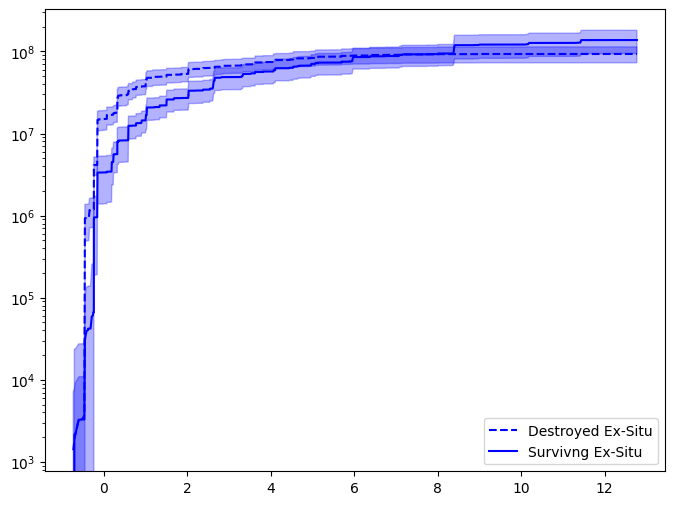

In [416]:
# Plot mean CDF with error regions
plt.figure(figsize=(8, 6))


plt.plot(t_vals, avg_val_d, label="Destroyed Ex-Situ", c="blue", ls="--")
plt.fill_between(t_vals, avg_val_d - std_val_d, avg_val_d + std_val_d, color="blue", alpha=0.3)

plt.plot(t_vals, avg_val_s, label="Survivng Ex-Situ", c="blue", ls="-")
plt.fill_between(t_vals, avg_val_s - std_val_s, avg_val_s + std_val_s, color="blue", alpha=0.3)

plt.yscale("log")
plt.legend()

In [433]:
def safe_interpolate(x, y, test_grid):
    interp_func = interp1d(x, y, kind="linear", bounds_error=False, fill_value=(0, 1))
    return interp_func(test_grid)

In [434]:
t_grid = np.linspace(np.min(time_lst[1:]), np.max(time_lst[1:]), 1000)

exsitu_surv_lst = []
exsitu_dead_lst = []

for it in range(it_min, it_max + 1):
    # for it in range(0, 1):
    it_id = iteration_name(it)

    y_surv = np.abs(mass_dict[it_id]["total_mass_diff_cumsum"]["survive"])
    y_dead = np.abs(mass_dict[it_id]["total_mass_diff_cumsum"]["dead"])

    exsitu_surv_lst.append(safe_interpolate(time_lst[1:], y_surv, t_grid))
    exsitu_dead_lst.append(safe_interpolate(time_lst[1:], y_dead, t_grid))

exsitu_surv_arr = np.array(exsitu_surv_lst)
exsitu_dead_arr = np.array(exsitu_dead_lst)

avg_exsitu_surv = np.mean(exsitu_surv_arr, axis=0)
std_exsitu_surv = np.std(exsitu_surv_arr, axis=0)

avg_exsitu_dead = np.mean(exsitu_dead_arr, axis=0)
std_exsitu_dead = np.std(exsitu_dead_arr, axis=0)

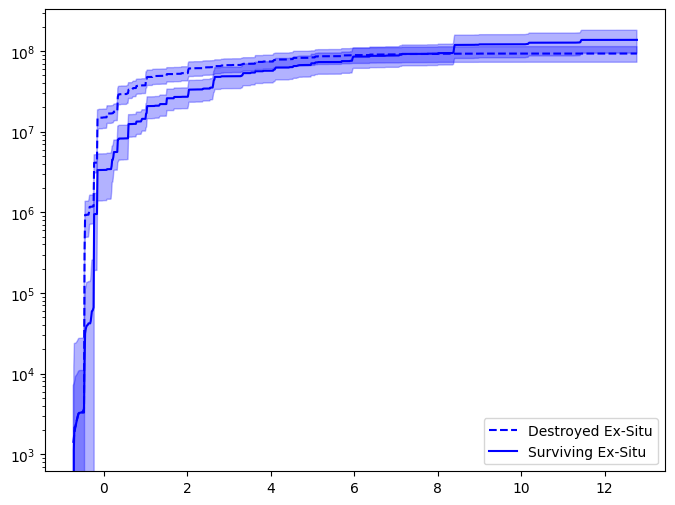

In [437]:
# Plot mean CDF with error regions
plt.figure(figsize=(8, 6))

plt.plot(t_grid, avg_exsitu_dead, label="Destroyed Ex-Situ", c="blue", ls="--")
plt.fill_between(
    t_grid,
    avg_exsitu_dead - std_exsitu_dead,
    avg_exsitu_dead + std_exsitu_dead,
    color="blue",
    alpha=0.3,
)

plt.plot(t_grid, avg_exsitu_surv, label="Surviving Ex-Situ", c="blue", ls="-")
plt.fill_between(
    t_grid,
    avg_exsitu_surv - std_exsitu_surv,
    avg_exsitu_surv + std_exsitu_surv,
    color="blue",
    alpha=0.3,
)

plt.yscale("log")
plt.legend()

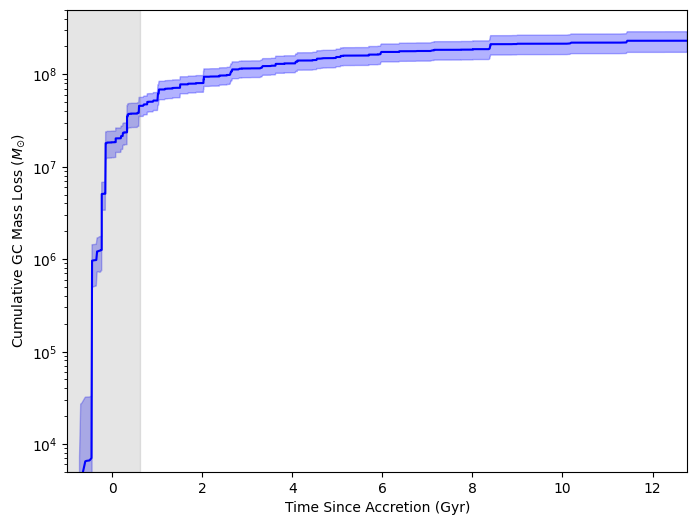

In [475]:
val_s = []

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)

    val_s.append(np.abs(mass_dict[it_id]["total_mass_diff_cumsum"]["both"]))

avg_val_s = np.mean(val_s, axis=0)
std_val_s = np.std(val_s, axis=0)

t_vals = mass_dict["time_acc"][1:]

# Plot mean CDF with error regions
plt.figure(figsize=(8, 6))

plt.plot(t_vals, avg_val_s, label="Survivng Ex-Situ", c="blue", ls="-")
plt.fill_between(t_vals, avg_val_s - std_val_s, avg_val_s + std_val_s, color="blue", alpha=0.3)

plt.axvspan(-2, max_time_acc, color="gray", alpha=0.2)

plt.xlim([-1, np.max(t_vals)])
plt.ylim([5 * 10**3, 5 * 10**8])

plt.xlabel("Time Since Accretion (Gyr)")
plt.ylabel(r"Cumulative GC Mass Loss ($M_{\odot}$)")

plt.yscale("log")

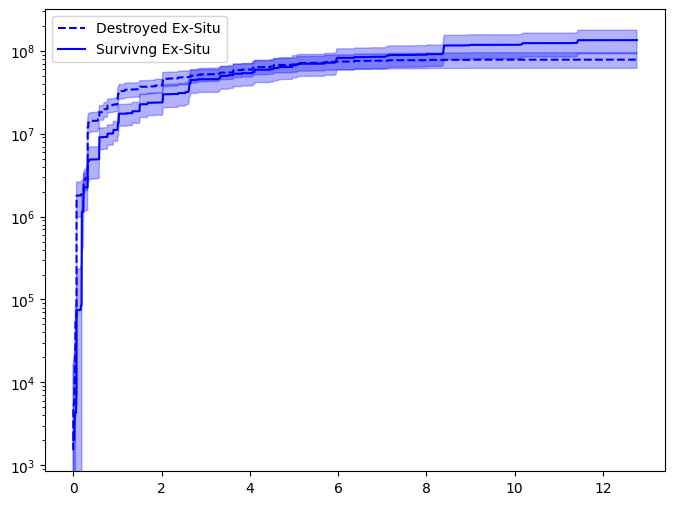

In [474]:
val_s = []

mask = np.array(mass_dict["time_acc"][1:]) >= 0
t_vals = np.array(mass_dict["time_acc"][1:])[mask]

val_s = []
val_d = []

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)

    surv_vals = np.array(mass_dict[it_id]["total_mass_diff"]["survive"])[mask]
    dead_vals = np.array(mass_dict[it_id]["total_mass_diff"]["dead"])[mask]

    val_s.append(np.abs(np.cumsum(surv_vals)))
    val_d.append(np.abs(np.cumsum(dead_vals)))

avg_val_s = np.mean(val_s, axis=0)
std_val_s = np.std(val_s, axis=0)

avg_val_d = np.mean(val_d, axis=0)
std_val_d = np.std(val_d, axis=0)


# Plot mean CDF with error regions
plt.figure(figsize=(8, 6))


plt.plot(t_vals, avg_val_d, label="Destroyed Ex-Situ", c="blue", ls="--")
plt.fill_between(t_vals, avg_val_d - std_val_d, avg_val_d + std_val_d, color="blue", alpha=0.3)

plt.plot(t_vals, avg_val_s, label="Survivng Ex-Situ", c="blue", ls="-")
plt.fill_between(t_vals, avg_val_s - std_val_s, avg_val_s + std_val_s, color="blue", alpha=0.3)

plt.yscale("log")
plt.legend()

# avg_val_s = np.mean(val_s, axis=0)
# std_val_s = np.std(val_s, axis=0)

# t_vals = mass_dict["time_acc"][1:]

# # Plot mean CDF with error regions
# plt.figure(figsize=(8, 6))

# plt.plot(t_vals, avg_val_s, label="Survivng Ex-Situ", c="blue", ls="-")
# plt.fill_between(t_vals, avg_val_s - std_val_s, avg_val_s + std_val_s, color="blue", alpha=0.3)

# plt.axvspan(-2, max_time_acc, color="gray", alpha=0.2)

# plt.xlim([-1, np.max(t_vals)])
# plt.ylim([5 * 10**3, 5 * 10**8])

# plt.xlabel("Time Since Accretion (Gyr)")
# plt.ylabel(r"Cumulative GC Mass Loss ($M_{\odot}$)")

# plt.yscale("log")

In [479]:
mass_dict["it000"]["total_mass_diff"]["both"]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -342780.50378139317,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -154581.40537452698,
 0.0,
 -9954.054173514247,
 0.0,
 0.0,
 0.0,
 -13203.294068574905,
 0.0,
 -2611913.0496536493,
 -2317.3946499675512,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -14318.323511719704,
 -11015.39309541881,
 0.0,
 -13153615.538103044,
 0.0,
 0.0,
 -453430.244144544,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -20019.575541079044,
 -4073.8027780354023,
 -22594.357702210546,
 0.0,
 0.0,
 -55966.576863870025,
 0.0,
 -32583.670100197196,
 0.0,
 0.0,
 -8072.350302487612,
 0.0,
 0.0,
 0.0,
 -19098.532585665584,
 -11550.481965079904,
 0.0,
 0.0,
 -5754.399373367429,
 -14155.541697576642,
 0.0,
 0.0,
 -1673443.1367482096,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -12387.965865299106,
 0.0,
 -10582.888297915459,
 0.0,
 -827965.3514129668,
 -10428.285891860723,
 0.0,
 -3556.3131856918335,
 0.0,
 0.0,
 -2978.516429424286,
 -1041475.6726733893,
 -379016.67113238573,
 0.0